In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from random import shuffle
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from sklearn.model_selection import KFold

In [4]:
BATCH_SIZE = 32     # number of images to be processed in a batch
NUM_EPOCHS = 30     # number of times the entire dataset is passed through the network
NUM_CLASSES = 1     # number of classes in the dataset
t = 224             # target size of image

In [5]:
# Load the InceptionV3 model
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(t, t, 3))

# Freeze the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Added layer to base model
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
predictions = keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

In [ ]:
# The model we will train
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.add(layers.Dropout(0.2))      # Dropout layer to prevent overfitting

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)      # Adam optimizer
loos_fn = keras.losses.BinaryCrossentropy()                 # Binary crossentropy loss function
model.compile(optimizer=optimizer, loss=loos_fn, metrics=['accuracy'])  # Compile the model

In [8]:
# Load the dataset
x_train = []
y_train = []
x_test = []
y_test = []

In [9]:
# Load the training data
dataTr = []

for filename in glob.glob(os.path.join('D:/SkinCancerDatasets/dataset/train/bcc/','*.jpg')):
    dataTr.append([1, cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC)])
for filename in glob.glob(os.path.join('D:/SkinCancerDatasets/dataset/train/scc/','*.jpg')):
    dataTr.append([0, cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC)])

print('Images loaded', len(dataTr))

Images loaded 6747


In [10]:
# Shuffle data
for i, j in dataTr:
    x_train.append(j)
    y_train.append(i)
x_train = np.array(x_train)/255 # Normalize
y_train = np.array(y_train)

In [11]:
for filename in glob.glob(os.path.join('D:/SkinCancerDatasets/dataset/validation/bcc/','*.jpg')):
    x_test.append(cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC))
    y_test.append(1)
for filename in glob.glob(os.path.join('D:/SkinCancerDatasets/dataset/validation/scc/','*.jpg')):
    x_test.append(cv.resize(cv.imread(filename), dsize=(t, t), interpolation=cv.INTER_CUBIC))
    y_test.append(0)

print('Images loaded', len(x_test))
print('Labels loaded', len(y_test))

Images loaded 2893
Labels loaded 2893


In [12]:
x_test = np.array(x_test)/255 # Normalize
y_test = np.array(y_test)

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 10,
    verbose = 0,
    restore_best_weights = True
)

In [ ]:
#validation across the training process
KFold = KFold(n_splits=5, shuffle=True,)
results = []

In [14]:
for train_idx, val_idx in KFold.split(x_train):
    x_val, y_val = x_train[val_idx], y_train[val_idx]
    history = model.fit(x_train[train_idx], y_train[train_idx], 
                        batch_size = BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        callbacks = [early_stopping],
                        validation_data = (x_test, y_test))
    results.append(model.evaluate(x_val, y_val))

Epoch 1/30
211/211 [==============================] - 301s 1s/step - loss: 0.5226 - accuracy: 0.7463 - val_loss: 0.4577 - val_accuracy: 0.7688
Epoch 2/30
211/211 [==============================] - 286s 1s/step - loss: 0.4024 - accuracy: 0.8128 - val_loss: 0.4141 - val_accuracy: 0.8120
Epoch 3/30
211/211 [==============================] - 283s 1s/step - loss: 0.3636 - accuracy: 0.8368 - val_loss: 0.4208 - val_accuracy: 0.7940
Epoch 4/30
211/211 [==============================] - 283s 1s/step - loss: 0.3190 - accuracy: 0.8607 - val_loss: 0.4260 - val_accuracy: 0.7885
Epoch 5/30
211/211 [==============================] - 283s 1s/step - loss: 0.3048 - accuracy: 0.8660 - val_loss: 0.3871 - val_accuracy: 0.8251
Epoch 6/30
211/211 [==============================] - 284s 1s/step - loss: 0.2499 - accuracy: 0.8948 - val_loss: 0.3785 - val_accuracy: 0.8299
Epoch 7/30
211/211 [==============================] - 282s 1s/step - loss: 0.2121 - accuracy: 0.9105 - val_loss: 0.4035 - val_accuracy: 0.8251

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss, test_acc*100.))

91/91 - 89s - loss: 0.3645 - accuracy: 0.8472 - 89s/epoch - 980ms/step
Test loss:  0.3645. Test accuracy:  84.72%


In [16]:
model.save('bcc_scc_inception_datagen_30ep_v3.h5')

c:\Users\josei\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


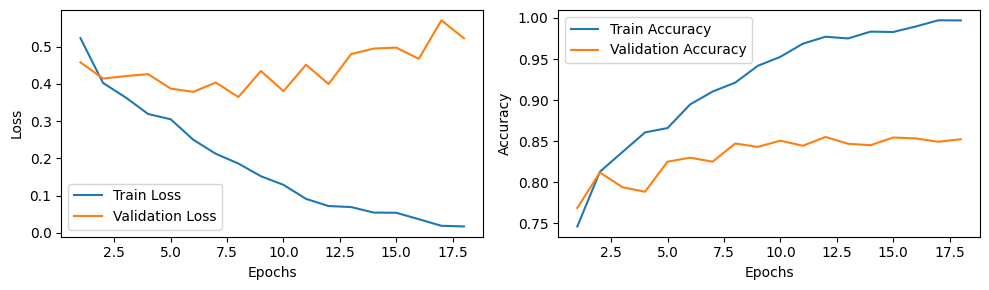

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tienes un historial llamado 'history' con registros de pérdida y precisión para entrenamiento y validación.
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Gráfico para pérdida
plt.sca(axes[0])
sns.lineplot(x=epochs, y=train_loss, label='Train Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para precisión
plt.sca(axes[1])
sns.lineplot(x=epochs, y=train_accuracy, label='Train Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Ajusta la disposición
plt.tight_layout()

# Muestra la figura
plt.show()


In [18]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

91/91 [==============================] - 89s 955ms/step


              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1496
           1       0.83      0.86      0.84      1397

    accuracy                           0.85      2893
   macro avg       0.85      0.85      0.85      2893
weighted avg       0.85      0.85      0.85      2893



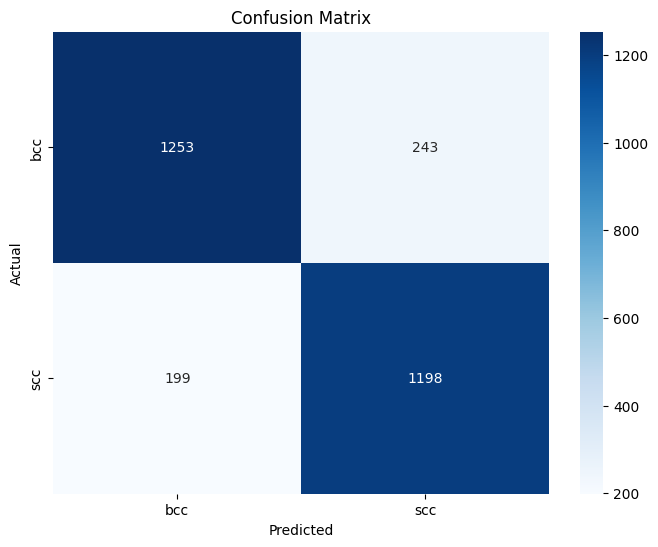

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Supongamos que tienes las etiquetas reales (y_true) y las predicciones (y_pred).
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

class_labels = ["bcc", "scc"]

# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

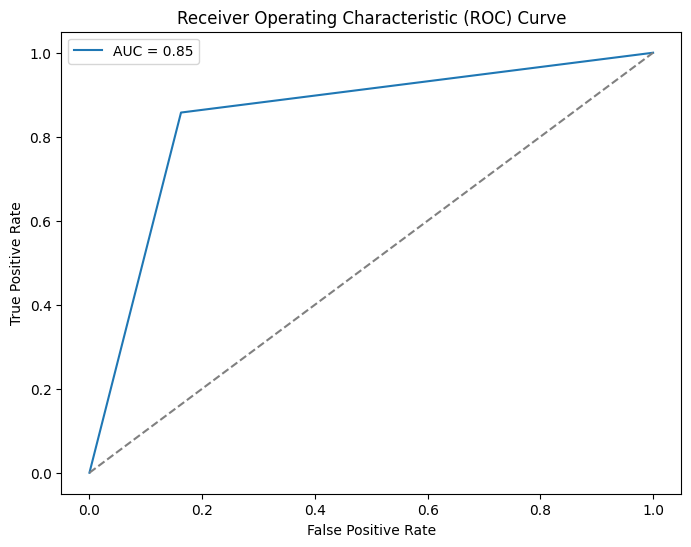

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

# Supongamos que tienes etiquetas reales (y_true) y probabilidades de predicción (y_probs).
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Crear un gráfico de la curva ROC
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

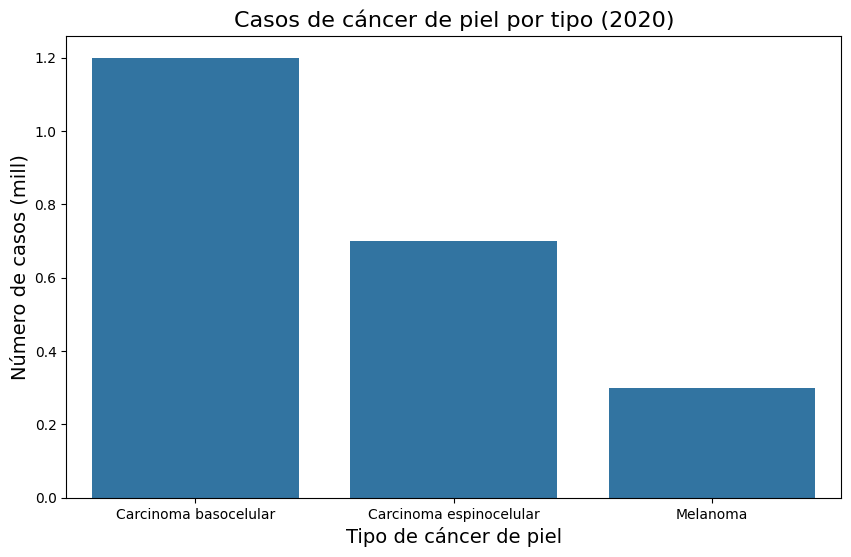

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Importamos los datos
data = {
    "tipo": ["Carcinoma basocelular", "Carcinoma espinocelular", "Melanoma"],
    "casos": [1.2, 0.7, 0.3],
}

# Creamos el gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="tipo", y="casos", data=data)

# Ajustamos los parámetros del gráfico
ax.set_title("Casos de cáncer de piel por tipo (2020)", fontsize=16)
ax.set_xlabel("Tipo de cáncer de piel", fontsize=14)
ax.set_ylabel("Número de casos (mill)", fontsize=14)

# Mostramos el gráfico
plt.show()